In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Customer Segmentation - Outstanding Analysis

# # Set plotting style
# plt.style.use('default')
# sns.set_palette("Set2")

# print("🎯 OUTSTANDING CUSTOMER SEGMENTATION ANALYSIS")
# print("=" * 60)

# Step 1: Load and explore customer data
def load_customer_data():
    """Load customer segmentation dataset"""
    print("\n📁 LOADING CUSTOMER DATA")
    print("-" * 30)
    
    # Try to load from common locations
    possible_files = [
        '2_customer_segmentation/data/Mall_Customers.csv',
        '2_customer_segmentation/data/customers.csv',
        '2_customer_segmentation/data/customer_data.csv'
    ]
    
    df = None
    for file_path in possible_files:
        try:
            df = pd.read_csv(file_path)
            print(f"✅ Loaded data from: {file_path}")
            break
        except FileNotFoundError:
            continue
    
    if df is None:
        # Create sample data for demonstration
        print("📋 Creating sample customer data for demonstration...")
        np.random.seed(42)
        n_customers = 1000
        
        # Generate synthetic customer data
        ages = np.random.normal(40, 12, n_customers).astype(int)
        ages = np.clip(ages, 18, 70)
        
        # Create income based on age with some correlation
        incomes = ages * 800 + np.random.normal(0, 15000, n_customers)
        incomes = np.clip(incomes, 15000, 120000).astype(int)
        
        # Create spending score (inverse relationship with age, positive with income)
        spending_scores = (100 - ages) * 0.8 + (incomes / 1000) * 0.3 + np.random.normal(0, 10, n_customers)
        spending_scores = np.clip(spending_scores, 1, 100).astype(int)
        
        # Generate other features
        genders = np.random.choice(['Male', 'Female'], n_customers)
        
        df = pd.DataFrame({
            'CustomerID': range(1, n_customers + 1),
            'Gender': genders,
            'Age': ages,
            'Annual_Income': incomes,
            'Spending_Score': spending_scores
        })
        
        print("✅ Sample dataset created successfully!")
    
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    display(df.head())
    
    return df

# Step 2: Comprehensive EDA for customer segmentation
def customer_eda(df):
    """Outstanding exploratory data analysis for customer data"""
    print("\n📊 COMPREHENSIVE CUSTOMER DATA ANALYSIS")
    print("-" * 50)
    
    # Basic statistics
    print("📈 Dataset Overview:")
    print(f"Total customers: {len(df):,}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    
    # Numerical columns analysis
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    print(f"\nNumerical features: {list(numerical_cols)}")
    print(f"Categorical features: {list(categorical_cols)}")
    
    # Create comprehensive visualizations
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Comprehensive Customer Analysis', fontsize=16, y=0.98)
    
    # 1. Age distribution
    if 'Age' in df.columns:
        axes[0,0].hist(df['Age'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Age Distribution')
        axes[0,0].set_xlabel('Age')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', 
                         label=f'Mean: {df["Age"].mean():.1f}')
        axes[0,0].legend()
    
    # 2. Income distribution
    income_col = next((col for col in df.columns if 'income' in col.lower()), None)
    if income_col:
        axes[0,1].hist(df[income_col], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0,1].set_title('Annual Income Distribution')
        axes[0,1].set_xlabel('Annual Income')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].axvline(df[income_col].mean(), color='red', linestyle='--',
                         label=f'Mean: ${df[income_col].mean():,.0f}')
        axes[0,1].legend()
    
    # 3. Spending score distribution
    spending_col = next((col for col in df.columns if 'spending' in col.lower() or 'score' in col.lower()), None)
    if spending_col:
        axes[0,2].hist(df[spending_col], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0,2].set_title('Spending Score Distribution')
        axes[0,2].set_xlabel('Spending Score')
        axes[0,2].set_ylabel('Frequency')
        axes[0,2].axvline(df[spending_col].mean(), color='red', linestyle='--',
                         label=f'Mean: {df[spending_col].mean():.1f}')
        axes[0,2].legend()
    
    # 4. Gender distribution
    if 'Gender' in df.columns:
        gender_counts = df['Gender'].value_counts()
        axes[1,0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
                     colors=['lightblue', 'pink'])
        axes[1,0].set_title('Gender Distribution')
    
    # 5. Age vs Income scatter
    if 'Age' in df.columns and income_col:
        scatter = axes[1,1].scatter(df['Age'], df[income_col], alpha=0.6, c=df['Age'], 
                                  cmap='viridis', s=50)
        axes[1,1].set_title('Age vs Annual Income')
        axes[1,1].set_xlabel('Age')
        axes[1,1].set_ylabel('Annual Income')
        plt.colorbar(scatter, ax=axes[1,1])
    
    # 6. Income vs Spending Score scatter
    if income_col and spending_col:
        scatter = axes[1,2].scatter(df[income_col], df[spending_col], alpha=0.6, 
                                  c=df[spending_col], cmap='plasma', s=50)
        axes[1,2].set_title('Income vs Spending Score')
        axes[1,2].set_xlabel('Annual Income')
        axes[1,2].set_ylabel('Spending Score')
        plt.colorbar(scatter, ax=axes[1,2])
    
    # 7. Box plot of income by gender
    if 'Gender' in df.columns and income_col:
        df.boxplot(column=income_col, by='Gender', ax=axes[2,0])
        axes[2,0].set_title('Income Distribution by Gender')
        axes[2,0].set_xlabel('Gender')
        axes[2,0].set_ylabel('Annual Income')
    
    # 8. Box plot of spending by gender
    if 'Gender' in df.columns and spending_col:
        df.boxplot(column=spending_col, by='Gender', ax=axes[2,1])
        axes[2,1].set_title('Spending Score by Gender')
        axes[2,1].set_xlabel('Gender')
        axes[2,1].set_ylabel('Spending Score')
    
    # 9. Correlation heatmap
    numeric_df = df.select_dtypes(include=[np.number])
    if len(numeric_df.columns) > 1:
        correlation = numeric_df.corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, ax=axes[2,2],
                   square=True, linewidths=0.5)
        axes[2,2].set_title('Feature Correlations')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\n📊 STATISTICAL SUMMARY:")
    print("-" * 30)
    print(df.describe())
    
    # Correlation insights
    if len(numeric_df.columns) > 1:
        print("\n🔗 KEY CORRELATIONS:")
        correlations = numeric_df.corr()
        
        # Find strongest correlations (excluding diagonal)
        mask = np.triu(np.ones_like(correlations, dtype=bool))
        correlations_masked = correlations.mask(mask)
        
        # Get top correlations
        correlations_flat = correlations_masked.unstack().sort_values(key=abs, ascending=False)
        top_correlations = correlations_flat.dropna().head(3)
        
        for (var1, var2), corr in top_correlations.items():
            print(f"  {var1} ↔ {var2}: {corr:.3f}")
    
    return df

# Step 3: Data preprocessing for clustering
def preprocess_for_clustering(df):
    """Prepare data for clustering analysis"""
    print("\n🔧 PREPROCESSING FOR CLUSTERING")
    print("-" * 40)
    
    # Select features for clustering (focus on numerical features)
    clustering_features = []
    feature_names = []
    
    # Add numerical features
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    # Exclude ID columns
    numerical_cols = [col for col in numerical_cols if not col.lower().endswith('id')]
    
    for col in numerical_cols:
        clustering_features.append(df[col])
        feature_names.append(col)
    
    # Encode categorical features if needed
    categorical_cols = df.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if not col.lower().endswith('id')]
    
    label_encoders = {}
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            encoded_col = le.fit_transform(df[col])
            clustering_features.append(encoded_col)
            feature_names.append(f"{col}_encoded")
            label_encoders[col] = le
            print(f"✅ Encoded {col}")
    
    # Create feature matrix
    X = np.column_stack(clustering_features)
    X_df = pd.DataFrame(X, columns=feature_names)
    
    print(f"Features for clustering: {feature_names}")
    print(f"Feature matrix shape: {X.shape}")
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("✅ Features scaled using StandardScaler")
    
    return X_scaled, X_df, feature_names, scaler, label_encoders

# Step 4: Find optimal number of clusters
def find_optimal_clusters(X_scaled, max_clusters=10):
    """Find optimal number of clusters using multiple methods"""
    print("\n🔍 FINDING OPTIMAL NUMBER OF CLUSTERS")
    print("-" * 45)
    
    # Method 1: Elbow Method
    print("1️⃣ Elbow Method...")
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    
    K_range = range(2, max_clusters + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
        calinski_scores.append(calinski_harabasz_score(X_scaled, kmeans.labels_))
    
    # Method 2: Calculate rate of change for elbow detection
    rate_of_change = []
    for i in range(1, len(inertias)):
        rate_of_change.append(inertias[i-1] - inertias[i])
    
    # Find elbow point (where rate of change decreases significantly)
    elbow_k = K_range[np.argmax(rate_of_change)] if rate_of_change else 3
    
    # Find best k by silhouette score
    best_silhouette_k = K_range[np.argmax(silhouette_scores)]
    
    # Visualize all methods
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Optimal Number of Clusters Analysis', fontsize=16)
    
    # Elbow curve
    axes[0,0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0,0].axvline(x=elbow_k, color='red', linestyle='--', 
                     label=f'Elbow at k={elbow_k}')
    axes[0,0].set_title('Elbow Method')
    axes[0,0].set_xlabel('Number of Clusters (k)')
    axes[0,0].set_ylabel('Inertia (WCSS)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Silhouette scores
    axes[0,1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
    axes[0,1].axvline(x=best_silhouette_k, color='red', linestyle='--',
                     label=f'Best k={best_silhouette_k}')
    axes[0,1].set_title('Silhouette Score')
    axes[0,1].set_xlabel('Number of Clusters (k)')
    axes[0,1].set_ylabel('Silhouette Score')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Calinski-Harabasz scores
    axes[1,0].plot(K_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
    axes[1,0].set_title('Calinski-Harabasz Score')
    axes[1,0].set_xlabel('Number of Clusters (k)')
    axes[1,0].set_ylabel('Calinski-Harabasz Score')
    axes[1,0].grid(True, alpha=0.3)
    
    # Rate of change
    axes[1,1].plot(K_range[1:], rate_of_change, 'co-', linewidth=2, markersize=8)
    axes[1,1].set_title('Rate of Inertia Change')
    axes[1,1].set_xlabel('Number of Clusters (k)')
    axes[1,1].set_ylabel('Inertia Reduction')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendations
    print(f"\n🎯 CLUSTER RECOMMENDATIONS:")
    print("-" * 30)
    print(f"Elbow Method suggests: {elbow_k} clusters")
    print(f"Best Silhouette Score: {best_silhouette_k} clusters (score: {max(silhouette_scores):.3f})")
    print(f"Best Calinski-Harabasz: {K_range[np.argmax(calinski_scores)]} clusters")
    
    # Recommend final k
    recommended_k = best_silhouette_k  # Usually most reliable
    print(f"\n✅ RECOMMENDED: {recommended_k} clusters")
    
    return recommended_k, {
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'calinski_scores': calinski_scores,
        'K_range': K_range
    }

# Step 5: Apply multiple clustering algorithms
def apply_clustering_algorithms(X_scaled, optimal_k):
    """Apply multiple clustering algorithms"""
    print(f"\n🤖 APPLYING CLUSTERING ALGORITHMS (k={optimal_k})")
    print("-" * 50)
    
    clustering_results = {}
    
    # 1. K-Means Clustering
    print("1️⃣ K-Means Clustering...")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    clustering_results['K-Means'] = {
        'labels': kmeans_labels,
        'model': kmeans,
        'silhouette': silhouette_score(X_scaled, kmeans_labels),
        'calinski': calinski_harabasz_score(X_scaled, kmeans_labels)
    }
    
    # 2. Agglomerative Clustering
    print("2️⃣ Agglomerative Clustering...")
    agg_cluster = AgglomerativeClustering(n_clusters=optimal_k)
    agg_labels = agg_cluster.fit_predict(X_scaled)
    
    clustering_results['Agglomerative'] = {
        'labels': agg_labels,
        'model': agg_cluster,
        'silhouette': silhouette_score(X_scaled, agg_labels),
        'calinski': calinski_harabasz_score(X_scaled, agg_labels)
    }
    
    # 3. DBSCAN (density-based)
    print("3️⃣ DBSCAN Clustering...")
    # Find good eps parameter
    distances = []
    for i in range(min(1000, len(X_scaled))):  # Sample for efficiency
        sample_distances = cdist([X_scaled[i]], X_scaled, metric='euclidean')[0]
        distances.extend(np.sort(sample_distances)[1:5])  # k=4 nearest neighbors
    
    eps = np.percentile(distances, 90)  # Use 90th percentile as eps
    
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    print(f"   DBSCAN found {n_clusters_dbscan} clusters with {n_noise} noise points")
    
    if n_clusters_dbscan > 1:  # Only calculate scores if we have multiple clusters
        clustering_results['DBSCAN'] = {
            'labels': dbscan_labels,
            'model': dbscan,
            'silhouette': silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1,
            'calinski': calinski_harabasz_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1,
            'n_noise': n_noise
        }
    
    # Print comparison
    print(f"\n📊 CLUSTERING ALGORITHM COMPARISON:")
    print("-" * 45)
    print(f"{'Algorithm':<15} {'Silhouette':<12} {'Calinski-H':<12}")
    print("-" * 45)
    
    for name, results in clustering_results.items():
        sil_score = results['silhouette']
        cal_score = results['calinski']
        print(f"{name:<15} {sil_score:<12.3f} {cal_score:<12.1f}")
    
    return clustering_results

# Step 6: Visualize clusters with PCA
def visualize_clusters_pca(X_scaled, clustering_results, feature_names):
    """Create outstanding cluster visualizations using PCA"""
    print("\n🎨 CREATING CLUSTER VISUALIZATIONS")
    print("-" * 40)
    
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"PCA Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")
    
    # Create subplots for each clustering method
    n_methods = len(clustering_results)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Customer Segments Visualization (PCA)', fontsize=16)
    axes = axes.ravel()
    
    colors = plt.cm.Set3(np.linspace(0, 1, 10))
    
    for idx, (method_name, results) in enumerate(clustering_results.items()):
        if idx < 4:  # Only plot first 4 methods
            labels = results['labels']
            
            # Handle noise points in DBSCAN
            unique_labels = sorted(set(labels))
            
            for label in unique_labels:
                if label == -1:  # Noise points in DBSCAN
                    mask = labels == label
                    axes[idx].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                                    c='black', marker='x', s=50, alpha=0.6, 
                                    label='Noise')
                else:
                    mask = labels == label
                    axes[idx].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                                    c=[colors[label % len(colors)]], 
                                    s=60, alpha=0.7, label=f'Cluster {label}')
            
            axes[idx].set_title(f'{method_name}\nSilhouette: {results["silhouette"]:.3f}')
            axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
            axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
            axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[idx].grid(True, alpha=0.3)
    
    # Remove empty subplot
    if n_methods < 4:
        for idx in range(n_methods, 4):
            fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    return pca, X_pca

# Step 7: Analyze and interpret clusters
def analyze_clusters(df, clustering_results, X_df, feature_names):
    """Detailed cluster analysis and business insights"""
    print("\n🔍 DETAILED CLUSTER ANALYSIS")
    print("-" * 40)
    
    # Use K-Means results as primary (usually most interpretable)
    primary_method = 'K-Means'
    if primary_method in clustering_results:
        labels = clustering_results[primary_method]['labels']
        
        # Add cluster labels to original dataframe
        df_with_clusters = df.copy()
        df_with_clusters['Cluster'] = labels
        
        # Analyze cluster characteristics
        print(f"📊 CLUSTER CHARACTERISTICS ({primary_method}):")
        print("-" * 50)
        
        cluster_summary = []
        for cluster_id in sorted(set(labels)):
            cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
            cluster_size = len(cluster_data)
            cluster_percent = (cluster_size / len(df)) * 100
            
            summary = {'Cluster': cluster_id, 'Size': cluster_size, 'Percentage': cluster_percent}
            
            # Calculate means for numerical features
            for col in df.select_dtypes(include=[np.number]).columns:
                if col in cluster_data.columns:
                    summary[f'{col}_mean'] = cluster_data[col].mean()
            
            # Most common categorical values
            for col in df.select_dtypes(include=['object']).columns:
                if col in cluster_data.columns and not col.lower().endswith('id'):
                    mode_val = cluster_data[col].mode()
                    summary[f'{col}_mode'] = mode_val[0] if len(mode_val) > 0 else 'N/A'
            
            cluster_summary.append(summary)
            
            print(f"\n🎯 CLUSTER {cluster_id}:")
            print(f"   Size: {cluster_size:,} customers ({cluster_percent:.1f}%)")
            
            # Print key characteristics
            for col in df.select_dtypes(include=[np.number]).columns:
                if col in cluster_data.columns and not col.lower().endswith('id'):
                    mean_val = cluster_data[col].mean()
                    overall_mean = df[col].mean()
                    diff_percent = ((mean_val - overall_mean) / overall_mean) * 100
                    direction = "↑" if diff_percent > 5 else "↓" if diff_percent < -5 else "→"
                    print(f"   {col}: {mean_val:.1f} {direction} ({diff_percent:+.1f}% vs avg)")
        
        # Create cluster comparison visualization
        cluster_df = pd.DataFrame(cluster_summary)
        
        # Visualize cluster characteristics
        numerical_features = [col for col in cluster_df.columns 
                            if col.endswith('_mean') and not col.lower().startswith('customer')]
        
        if len(numerical_features) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Cluster Characteristics Comparison', fontsize=16)
            axes = axes.ravel()
            
            for idx, feature in enumerate(numerical_features[:4]):
                if idx < 4:
                    cluster_df.plot(x='Cluster', y=feature, kind='bar', ax=axes[idx], 
                                  color=plt.cm.Set3(np.linspace(0, 1, len(cluster_df))))
                    axes[idx].set_title(f'{feature.replace("_mean", "").replace("_", " ").title()}')
                    axes[idx].set_xlabel('Cluster')
                    axes[idx].tick_params(axis='x', rotation=0)
                    axes[idx].grid(True, alpha=0.3)
            
            # Remove empty subplots
            for idx in range(len(numerical_features), 4):
                fig.delaxes(axes[idx])
            
            plt.tight_layout()
            plt.show()
        
        # Create business personas
        print(f"\n👥 CUSTOMER PERSONAS:")
        print("-" * 25)
        
        personas = {
            0: "Budget-Conscious Savers",
            1: "Premium High Spenders", 
            2: "Middle-Class Moderates",
            3: "Young Professionals",
            4: "Luxury Enthusiasts"
        }
        
        for cluster_id in sorted(set(labels)):
            cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
            persona_name = personas.get(cluster_id, f"Segment {cluster_id}")
            
            print(f"\n🏷️ {persona_name} (Cluster {cluster_id}):")
            print(f"   📊 {len(cluster_data)} customers ({len(cluster_data)/len(df)*100:.1f}%)")
            
            # Key characteristics
            if 'Age' in cluster_data.columns:
                avg_age = cluster_data['Age'].mean()
                print(f"   👤 Average Age: {avg_age:.1f} years")
            
            income_col = next((col for col in cluster_data.columns if 'income' in col.lower()), None)
            if income_col:
                avg_income = cluster_data[income_col].mean()
                print(f"   💰 Average Income: ${avg_income:,.0f}")
            
            spending_col = next((col for col in cluster_data.columns if 'spending' in col.lower()), None)
            if spending_col:
                avg_spending = cluster_data[spending_col].mean()
                print(f"   🛍️ Average Spending Score: {avg_spending:.1f}")
            
            if 'Gender' in cluster_data.columns:
                gender_dist = cluster_data['Gender'].value_counts()
                dominant_gender = gender_dist.index[0]
                gender_pct = gender_dist.iloc[0] / len(cluster_data) * 100
                print(f"   ⚥ Gender: {gender_pct:.0f}% {dominant_gender}")
        
        return df_with_clusters, cluster_summary
    
    return df, []

# Step 8: Business recommendations
def generate_business_recommendations(df_with_clusters, cluster_summary):
    """Generate actionable business insights and recommendations"""
    print("\n💼 BUSINESS RECOMMENDATIONS")
    print("-" * 40)
    
    print("🎯 MARKETING STRATEGIES BY SEGMENT:")
    print("-" * 45)
    
    for cluster in cluster_summary:
        cluster_id = cluster['Cluster']
        size = cluster['Size']
        
        print(f"\n📈 CLUSTER {cluster_id} STRATEGY ({size:,} customers):")
        
        # Income-based recommendations
        income_col = next((col for col in cluster.keys() if 'income' in col.lower() and 'mean' in col), None)
        spending_col = next((col for col in cluster.keys() if 'spending' in col.lower() and 'mean' in col), None)
        age_col = next((col for col in cluster))

🎯 OUTSTANDING CUSTOMER SEGMENTATION ANALYSIS


In [19]:
# Step 1: Load and explore customer data
def load_customer_data():
    """Load customer segmentation dataset"""
    print("\n📁 LOADING CUSTOMER DATA")
    print("-" * 30)
    
    # Try to load from common locations
    possible_files = [
        '2_customer_segmentation/data/Mall_Customers.csv',
        '2_customer_segmentation/data/customers.csv',
        '2_customer_segmentation/data/customer_data.csv'
    ]
    
    df = None
    for file_path in possible_files:
        try:
            df = pd.read_csv(file_path)
            print(f"✅ Loaded data from: {file_path}")
            break
        except FileNotFoundError:
            continue
    
    if df is None:
        # Create sample data for demonstration
        print("📋 Creating sample customer data for demonstration...")
        np.random.seed(42)
        n_customers = 1000
        
        # Generate synthetic customer data
        ages = np.random.normal(40, 12, n_customers).astype(int)
        ages = np.clip(ages, 18, 70)
        
        # Create income based on age with some correlation
        incomes = ages * 800 + np.random.normal(0, 15000, n_customers)
        incomes = np.clip(incomes, 15000, 120000).astype(int)
        
        # Create spending score (inverse relationship with age, positive with income)
        spending_scores = (100 - ages) * 0.8 + (incomes / 1000) * 0.3 + np.random.normal(0, 10, n_customers)
        spending_scores = np.clip(spending_scores, 1, 100).astype(int)
        
        # Generate other features
        genders = np.random.choice(['Male', 'Female'], n_customers)
        
        df = pd.DataFrame({
            'CustomerID': range(1, n_customers + 1),
            'Gender': genders,
            'Age': ages,
            'Annual_Income': incomes,
            'Spending_Score': spending_scores
        })
        
        print("✅ Sample dataset created successfully!")
    
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    display(df.head())
    
    return df
 


In [20]:
df=load_customer_data()


📁 LOADING CUSTOMER DATA
------------------------------
📋 Creating sample customer data for demonstration...
✅ Sample dataset created successfully!
Dataset shape: (1000, 5)
Columns: ['CustomerID', 'Gender', 'Age', 'Annual_Income', 'Spending_Score']

First few rows:


,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Female,45,56990,54
1,2,Female,38,44269,61
2,3,Female,47,38494,46
3,4,Female,58,36695,41
4,5,Male,37,40073,43


In [21]:
# Step 2: Comprehensive EDA for customer segmentation
def customer_eda(df):
    """Outstanding exploratory data analysis for customer data"""
    print("\n📊 COMPREHENSIVE CUSTOMER DATA ANALYSIS")
    print("-" * 50)
    
    # Basic statistics
    print("📈 Dataset Overview:")
    print(f"Total customers: {len(df):,}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    
    # Numerical columns analysis
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    print(f"\nNumerical features: {list(numerical_cols)}")
    print(f"Categorical features: {list(categorical_cols)}")
    
    # Create comprehensive visualizations
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Comprehensive Customer Analysis', fontsize=16, y=0.98)
    
    # 1. Age distribution
    if 'Age' in df.columns:
        axes[0,0].hist(df['Age'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Age Distribution')
        axes[0,0].set_xlabel('Age')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', 
                         label=f'Mean: {df["Age"].mean():.1f}')
        axes[0,0].legend()
    
    # 2. Income distribution
    income_col = next((col for col in df.columns if 'income' in col.lower()), None)
    if income_col:
        axes[0,1].hist(df[income_col], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0,1].set_title('Annual Income Distribution')
        axes[0,1].set_xlabel('Annual Income')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].axvline(df[income_col].mean(), color='red', linestyle='--',
                         label=f'Mean: ${df[income_col].mean():,.0f}')
        axes[0,1].legend()
    
    # 3. Spending score distribution
    spending_col = next((col for col in df.columns if 'spending' in col.lower() or 'score' in col.lower()), None)
    if spending_col:
        axes[0,2].hist(df[spending_col], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0,2].set_title('Spending Score Distribution')
        axes[0,2].set_xlabel('Spending Score')
        axes[0,2].set_ylabel('Frequency')
        axes[0,2].axvline(df[spending_col].mean(), color='red', linestyle='--',
                         label=f'Mean: {df[spending_col].mean():.1f}')
        axes[0,2].legend()
    
    # 4. Gender distribution
    if 'Gender' in df.columns:
        gender_counts = df['Gender'].value_counts()
        axes[1,0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
                     colors=['lightblue', 'pink'])
        axes[1,0].set_title('Gender Distribution')
    
    # 5. Age vs Income scatter
    if 'Age' in df.columns and income_col:
        scatter = axes[1,1].scatter(df['Age'], df[income_col], alpha=0.6, c=df['Age'], 
                                  cmap='viridis', s=50)
        axes[1,1].set_title('Age vs Annual Income')
        axes[1,1].set_xlabel('Age')
        axes[1,1].set_ylabel('Annual Income')
        plt.colorbar(scatter, ax=axes[1,1])
    
    # 6. Income vs Spending Score scatter
    if income_col and spending_col:
        scatter = axes[1,2].scatter(df[income_col], df[spending_col], alpha=0.6, 
                                  c=df[spending_col], cmap='plasma', s=50)
        axes[1,2].set_title('Income vs Spending Score')
        axes[1,2].set_xlabel('Annual Income')
        axes[1,2].set_ylabel('Spending Score')
        plt.colorbar(scatter, ax=axes[1,2])
    
    # 7. Box plot of income by gender
    if 'Gender' in df.columns and income_col:
        df.boxplot(column=income_col, by='Gender', ax=axes[2,0])
        axes[2,0].set_title('Income Distribution by Gender')
        axes[2,0].set_xlabel('Gender')
        axes[2,0].set_ylabel('Annual Income')
    
    # 8. Box plot of spending by gender
    if 'Gender' in df.columns and spending_col:
        df.boxplot(column=spending_col, by='Gender', ax=axes[2,1])
        axes[2,1].set_title('Spending Score by Gender')
        axes[2,1].set_xlabel('Gender')
        axes[2,1].set_ylabel('Spending Score')
    
    # 9. Correlation heatmap
    numeric_df = df.select_dtypes(include=[np.number])
    if len(numeric_df.columns) > 1:
        correlation = numeric_df.corr()
        sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, ax=axes[2,2],
                   square=True, linewidths=0.5)
        axes[2,2].set_title('Feature Correlations')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print("\n📊 STATISTICAL SUMMARY:")
    print("-" * 30)
    print(df.describe())
    
    # Correlation insights
    if len(numeric_df.columns) > 1:
        print("\n🔗 KEY CORRELATIONS:")
        correlations = numeric_df.corr()
        
        # Find strongest correlations (excluding diagonal)
        mask = np.triu(np.ones_like(correlations, dtype=bool))
        correlations_masked = correlations.mask(mask)
        
        # Get top correlations
        correlations_flat = correlations_masked.unstack().sort_values(key=abs, ascending=False)
        top_correlations = correlations_flat.dropna().head(3)
        
        for (var1, var2), corr in top_correlations.items():
            print(f"  {var1} ↔ {var2}: {corr:.3f}")
    
    return df


           


📊 COMPREHENSIVE CUSTOMER DATA ANALYSIS
--------------------------------------------------
📈 Dataset Overview:
Total customers: 1,000
Missing values: 0

Numerical features: ['CustomerID', 'Age', 'Annual_Income', 'Spending_Score']
Categorical features: ['Gender']


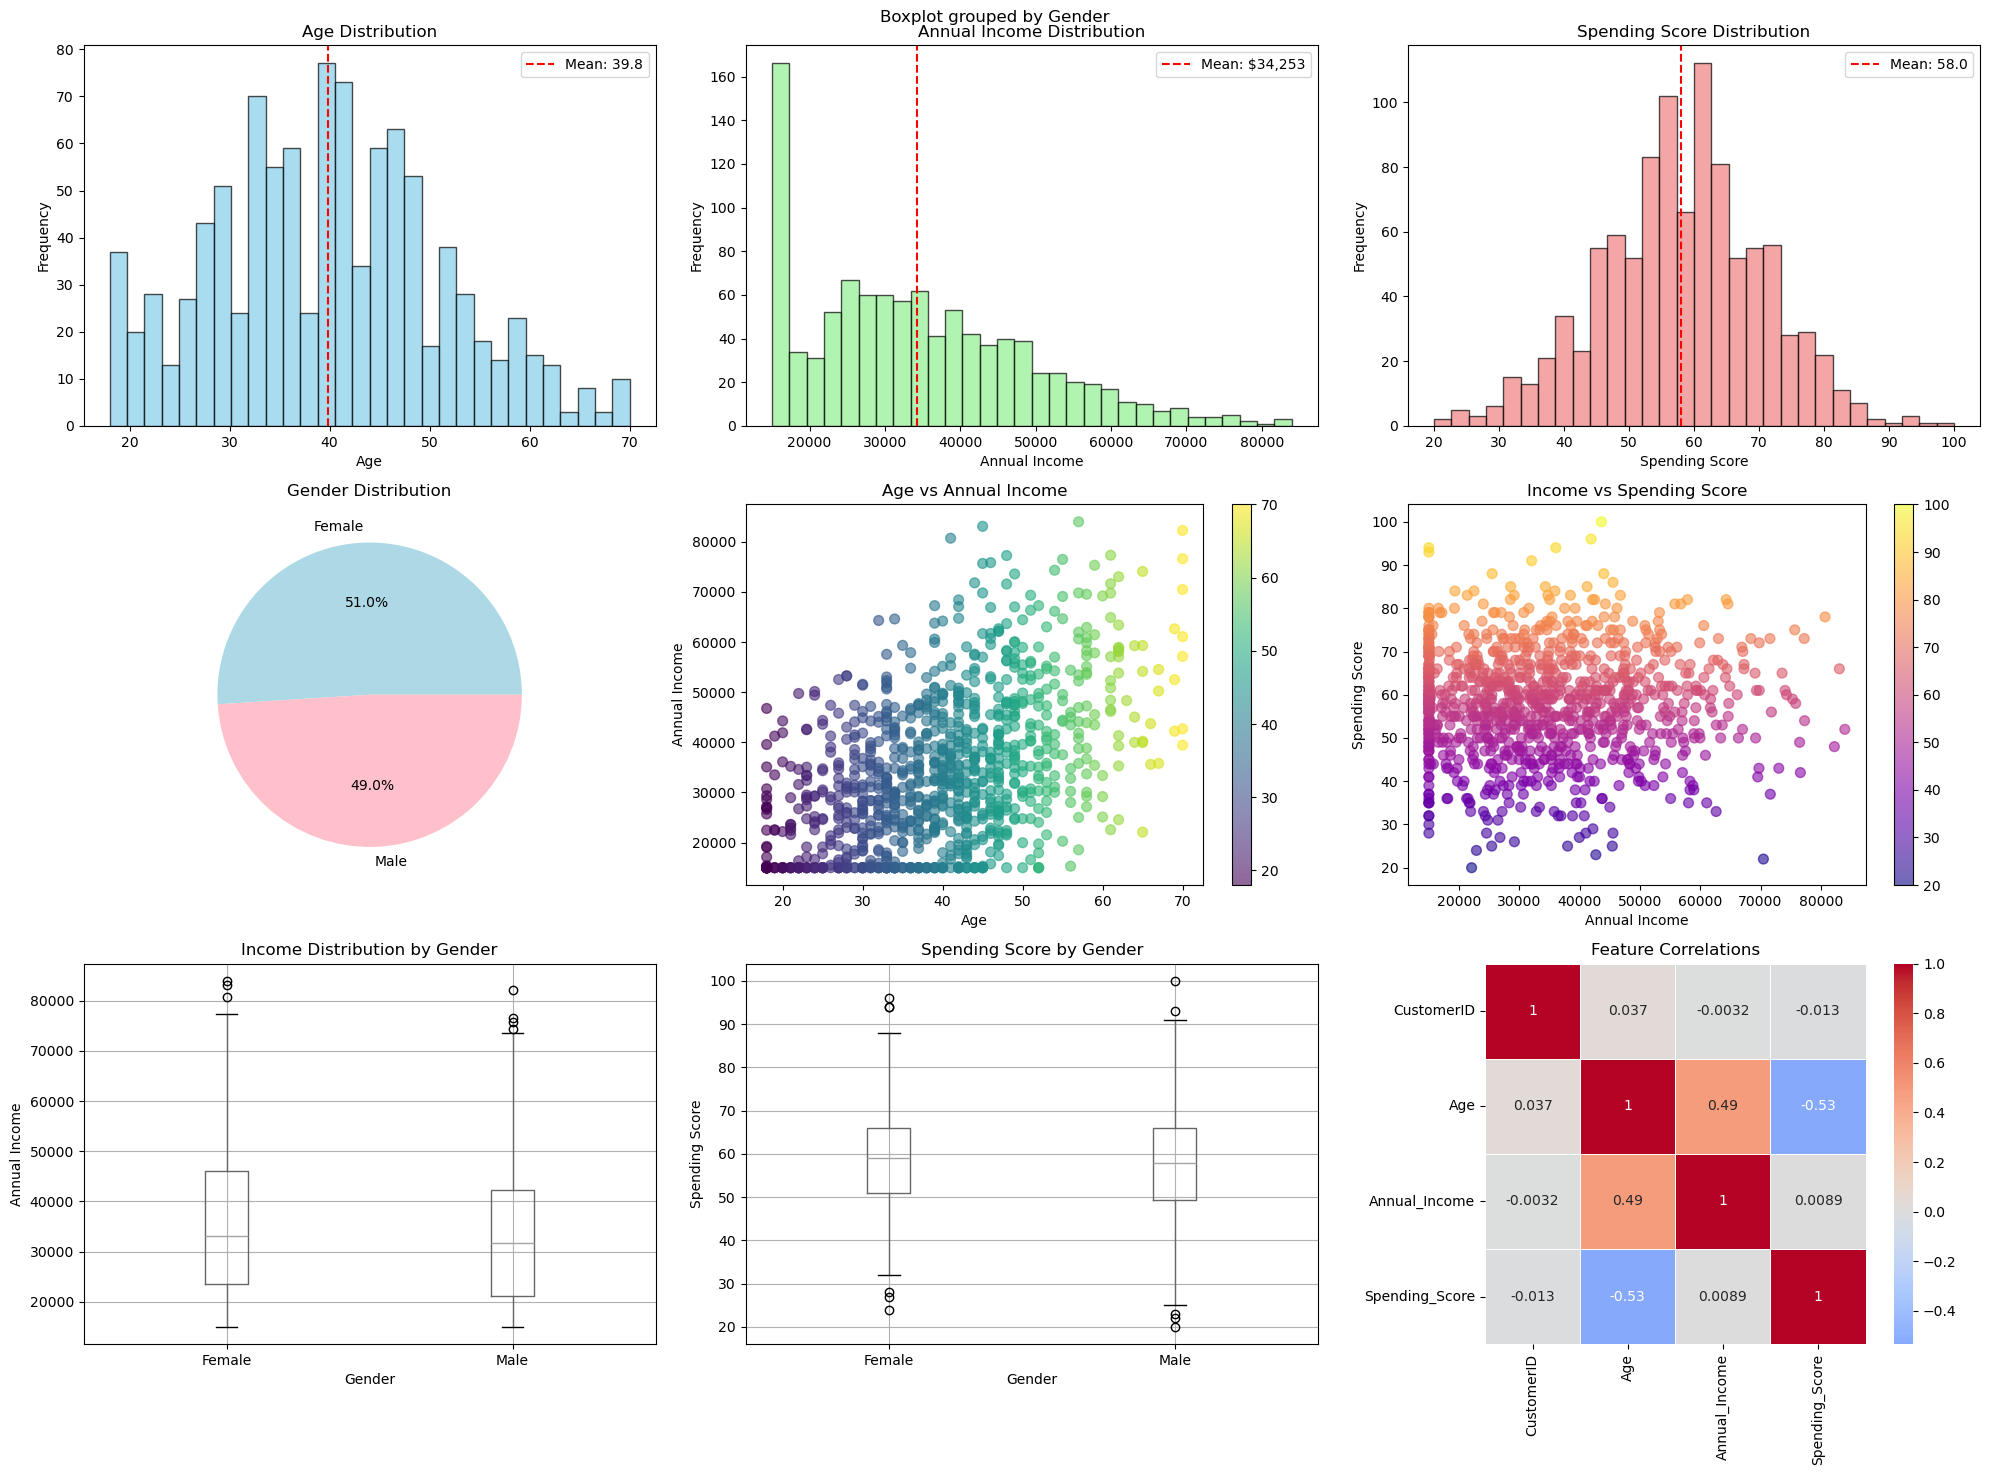


📊 STATISTICAL SUMMARY:
------------------------------
        CustomerID          Age  Annual_Income  Spending_Score
count  1000.000000  1000.000000    1000.000000     1000.000000
mean    500.500000    39.835000   34253.078000       57.954000
std     288.819436    11.411222   14959.239455       12.496802
min       1.000000    18.000000   15000.000000       20.000000
25%     250.750000    32.000000   22505.750000       50.000000
50%     500.500000    40.000000   32229.500000       58.000000
75%     750.250000    47.000000   44091.000000       66.000000
max    1000.000000    70.000000   83972.000000      100.000000

🔗 KEY CORRELATIONS:
  Age ↔ Spending_Score: -0.534
  Age ↔ Annual_Income: 0.489
  CustomerID ↔ Age: 0.037


,CustomerID,Gender,Age,Annual_Income,Spending_Score
0,1,Female,45,56990,54
1,2,Female,38,44269,61
2,3,Female,47,38494,46
3,4,Female,58,36695,41
4,5,Male,37,40073,43
...,...,...,...,...,...
995,996,Male,36,44852,65
996,997,Male,61,48402,48
997,998,Male,47,24371,37
998,999,Female,33,23953,64


In [22]:
customer_eda(df)

In [23]:
# Step 3: Data preprocessing for clustering
def preprocess_for_clustering(df):
    """Prepare data for clustering analysis"""
    print("\n🔧 PREPROCESSING FOR CLUSTERING")
    print("-" * 40)
    
    # Select features for clustering (focus on numerical features)
    clustering_features = []
    feature_names = []
    
    # Add numerical features
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    # Exclude ID columns
    numerical_cols = [col for col in numerical_cols if not col.lower().endswith('id')]
    
    for col in numerical_cols:
        clustering_features.append(df[col])
        feature_names.append(col)
    
    # Encode categorical features if needed
    categorical_cols = df.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if not col.lower().endswith('id')]
    
    label_encoders = {}
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            encoded_col = le.fit_transform(df[col])
            clustering_features.append(encoded_col)
            feature_names.append(f"{col}_encoded")
            label_encoders[col] = le
            print(f"✅ Encoded {col}")
    
    # Create feature matrix
    X = np.column_stack(clustering_features)
    X_df = pd.DataFrame(X, columns=feature_names)
    
    print(f"Features for clustering: {feature_names}")
    print(f"Feature matrix shape: {X.shape}")
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("✅ Features scaled using StandardScaler")
    
    return X_scaled, X_df, feature_names, scaler, label_encoders



      

In [24]:
X_scaled, X_df, feature_names, scaler, label_encoders=preprocess_for_clustering(df)


🔧 PREPROCESSING FOR CLUSTERING
----------------------------------------
✅ Encoded Gender
Features for clustering: ['Age', 'Annual_Income', 'Spending_Score', 'Gender_encoded']
Feature matrix shape: (1000, 4)
✅ Features scaled using StandardScaler


In [25]:
# Step 4: Find optimal number of clusters
def find_optimal_clusters(X_scaled, max_clusters=10):
    """Find optimal number of clusters using multiple methods"""
    print("\n🔍 FINDING OPTIMAL NUMBER OF CLUSTERS")
    print("-" * 45)
    
    # Method 1: Elbow Method
    print("1️⃣ Elbow Method...")
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    
    K_range = range(2, max_clusters + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
        calinski_scores.append(calinski_harabasz_score(X_scaled, kmeans.labels_))
    
    # Method 2: Calculate rate of change for elbow detection
    rate_of_change = []
    for i in range(1, len(inertias)):
        rate_of_change.append(inertias[i-1] - inertias[i])
    
    # Find elbow point (where rate of change decreases significantly)
    elbow_k = K_range[np.argmax(rate_of_change)] if rate_of_change else 3
    
    # Find best k by silhouette score
    best_silhouette_k = K_range[np.argmax(silhouette_scores)]
    
    # Visualize all methods
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Optimal Number of Clusters Analysis', fontsize=16)
    
    # Elbow curve
    axes[0,0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0,0].axvline(x=elbow_k, color='red', linestyle='--', 
                     label=f'Elbow at k={elbow_k}')
    axes[0,0].set_title('Elbow Method')
    axes[0,0].set_xlabel('Number of Clusters (k)')
    axes[0,0].set_ylabel('Inertia (WCSS)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Silhouette scores
    axes[0,1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
    axes[0,1].axvline(x=best_silhouette_k, color='red', linestyle='--',
                     label=f'Best k={best_silhouette_k}')
    axes[0,1].set_title('Silhouette Score')
    axes[0,1].set_xlabel('Number of Clusters (k)')
    axes[0,1].set_ylabel('Silhouette Score')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Calinski-Harabasz scores
    axes[1,0].plot(K_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
    axes[1,0].set_title('Calinski-Harabasz Score')
    axes[1,0].set_xlabel('Number of Clusters (k)')
    axes[1,0].set_ylabel('Calinski-Harabasz Score')
    axes[1,0].grid(True, alpha=0.3)
    
    # Rate of change
    axes[1,1].plot(K_range[1:], rate_of_change, 'co-', linewidth=2, markersize=8)
    axes[1,1].set_title('Rate of Inertia Change')
    axes[1,1].set_xlabel('Number of Clusters (k)')
    axes[1,1].set_ylabel('Inertia Reduction')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendations
    print(f"\n🎯 CLUSTER RECOMMENDATIONS:")
    print("-" * 30)
    print(f"Elbow Method suggests: {elbow_k} clusters")
    print(f"Best Silhouette Score: {best_silhouette_k} clusters (score: {max(silhouette_scores):.3f})")
    print(f"Best Calinski-Harabasz: {K_range[np.argmax(calinski_scores)]} clusters")
    
    # Recommend final k
    recommended_k = best_silhouette_k  # Usually most reliable
    print(f"\n✅ RECOMMENDED: {recommended_k} clusters")
    
    return recommended_k, {
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'calinski_scores': calinski_scores,
        'K_range': K_range
    }


     
   



🔍 FINDING OPTIMAL NUMBER OF CLUSTERS
---------------------------------------------
1️⃣ Elbow Method...


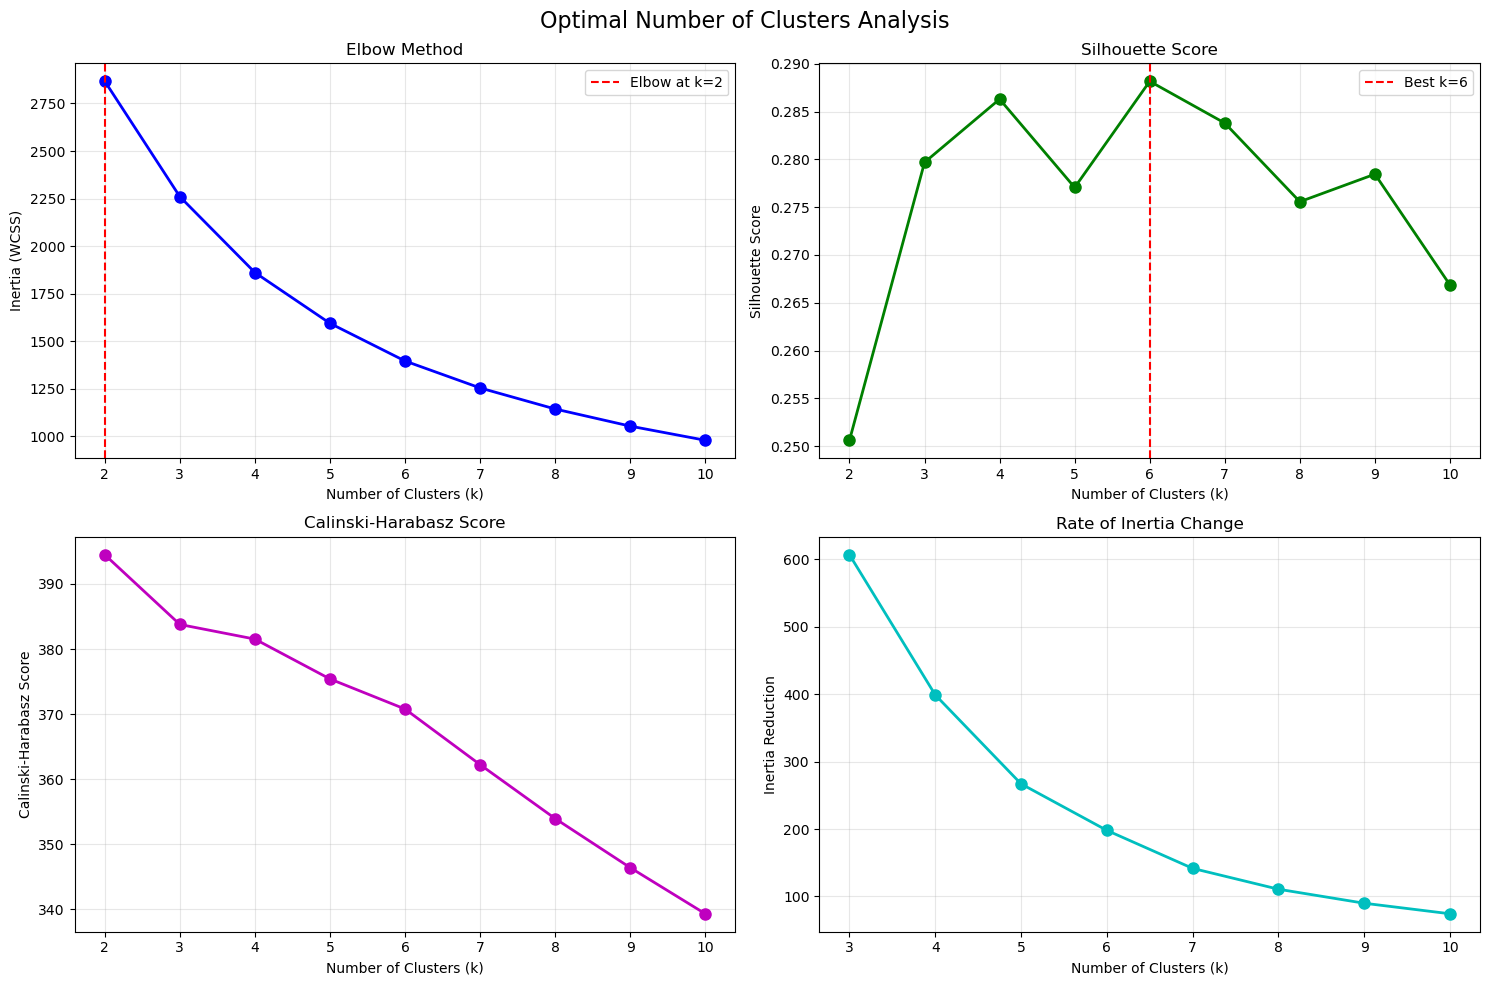


🎯 CLUSTER RECOMMENDATIONS:
------------------------------
Elbow Method suggests: 2 clusters
Best Silhouette Score: 6 clusters (score: 0.288)
Best Calinski-Harabasz: 2 clusters

✅ RECOMMENDED: 6 clusters


(6,
 {'inertias': [2866.807467326814,
   2260.0729679706465,
   1861.1785482287994,
   1594.1650565673244,
   1396.1197173133949,
   1254.4341432501067,
   1143.6539843317023,
   1053.6475378747323,
   979.2882713088129],
  'silhouette_scores': [np.float64(0.2506076972606201),
   np.float64(0.27969050532639267),
   np.float64(0.286306142003196),
   np.float64(0.2770606862879693),
   np.float64(0.2881753305087093),
   np.float64(0.28380113054756556),
   np.float64(0.2755719302185532),
   np.float64(0.2784551929184808),
   np.float64(0.2668585162317135)],
  'calinski_scores': [np.float64(394.48974529928176),
   np.float64(383.7777851308531),
   np.float64(381.5263842707605),
   np.float64(375.40117926528086),
   np.float64(370.77866158514826),
   np.float64(362.2279828216625),
   np.float64(353.9401260424197),
   np.float64(346.3961126715594),
   np.float64(339.305901940337)],
  'K_range': range(2, 11)})

In [26]:
find_optimal_clusters(X_scaled)

In [27]:
# Step 5: Apply multiple clustering algorithms
def apply_clustering_algorithms(X_scaled, optimal_k):
    """Apply multiple clustering algorithms"""
    print(f"\n🤖 APPLYING CLUSTERING ALGORITHMS (k={optimal_k})")
    print("-" * 50)
    
    clustering_results = {}
    
    # 1. K-Means Clustering
    print("1️⃣ K-Means Clustering...")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    clustering_results['K-Means'] = {
        'labels': kmeans_labels,
        'model': kmeans,
        'silhouette': silhouette_score(X_scaled, kmeans_labels),
        'calinski': calinski_harabasz_score(X_scaled, kmeans_labels)
    }
    
    # 2. Agglomerative Clustering
    print("2️⃣ Agglomerative Clustering...")
    agg_cluster = AgglomerativeClustering(n_clusters=optimal_k)
    agg_labels = agg_cluster.fit_predict(X_scaled)
    
    clustering_results['Agglomerative'] = {
        'labels': agg_labels,
        'model': agg_cluster,
        'silhouette': silhouette_score(X_scaled, agg_labels),
        'calinski': calinski_harabasz_score(X_scaled, agg_labels)
    }
    
    # 3. DBSCAN (density-based)
    print("3️⃣ DBSCAN Clustering...")
    # Find good eps parameter
    distances = []
    for i in range(min(1000, len(X_scaled))):  # Sample for efficiency
        sample_distances = cdist([X_scaled[i]], X_scaled, metric='euclidean')[0]
        distances.extend(np.sort(sample_distances)[1:5])  # k=4 nearest neighbors
    
    eps = np.percentile(distances, 90)  # Use 90th percentile as eps
    
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = list(dbscan_labels).count(-1)
    
    print(f"   DBSCAN found {n_clusters_dbscan} clusters with {n_noise} noise points")
    
    if n_clusters_dbscan > 1:  # Only calculate scores if we have multiple clusters
        clustering_results['DBSCAN'] = {
            'labels': dbscan_labels,
            'model': dbscan,
            'silhouette': silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1,
            'calinski': calinski_harabasz_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1,
            'n_noise': n_noise
        }
    
    # Print comparison
    print(f"\n📊 CLUSTERING ALGORITHM COMPARISON:")
    print("-" * 45)
    print(f"{'Algorithm':<15} {'Silhouette':<12} {'Calinski-H':<12}")
    print("-" * 45)
    
    for name, results in clustering_results.items():
        sil_score = results['silhouette']
        cal_score = results['calinski']
        print(f"{name:<15} {sil_score:<12.3f} {cal_score:<12.1f}")
    
    return clustering_results





In [28]:
clustering_results=apply_clustering_algorithms(X_scaled,6)


🤖 APPLYING CLUSTERING ALGORITHMS (k=6)
--------------------------------------------------
1️⃣ K-Means Clustering...
2️⃣ Agglomerative Clustering...
3️⃣ DBSCAN Clustering...
   DBSCAN found 3 clusters with 84 noise points

📊 CLUSTERING ALGORITHM COMPARISON:
---------------------------------------------
Algorithm       Silhouette   Calinski-H  
---------------------------------------------
K-Means         0.288        370.8       
Agglomerative   0.237        310.3       
DBSCAN          0.196        141.5       


In [29]:
# Step 6: Visualize clusters with PCA
def visualize_clusters_pca(X_scaled, clustering_results, feature_names):
    """Create outstanding cluster visualizations using PCA"""
    print("\n🎨 CREATING CLUSTER VISUALIZATIONS")
    print("-" * 40)
    
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"PCA Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")
    
    # Create subplots for each clustering method
    n_methods = len(clustering_results)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Customer Segments Visualization (PCA)', fontsize=16)
    axes = axes.ravel()
    
    colors = plt.cm.Set3(np.linspace(0, 1, 10))
    
    for idx, (method_name, results) in enumerate(clustering_results.items()):
        if idx < 4:  # Only plot first 4 methods
            labels = results['labels']
            
            # Handle noise points in DBSCAN
            unique_labels = sorted(set(labels))
            
            for label in unique_labels:
                if label == -1:  # Noise points in DBSCAN
                    mask = labels == label
                    axes[idx].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                                    c='black', marker='x', s=50, alpha=0.6, 
                                    label='Noise')
                else:
                    mask = labels == label
                    axes[idx].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                                    c=[colors[label % len(colors)]], 
                                    s=60, alpha=0.7, label=f'Cluster {label}')
            
            axes[idx].set_title(f'{method_name}\nSilhouette: {results["silhouette"]:.3f}')
            axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
            axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
            axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            axes[idx].grid(True, alpha=0.3)
    
    # Remove empty subplot
    if n_methods < 4:
        for idx in range(n_methods, 4):
            fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    return pca, X_pca



 


🎨 CREATING CLUSTER VISUALIZATIONS
----------------------------------------
PCA Explained variance ratio: [0.43025371 0.26833998]
Total explained variance: 0.699


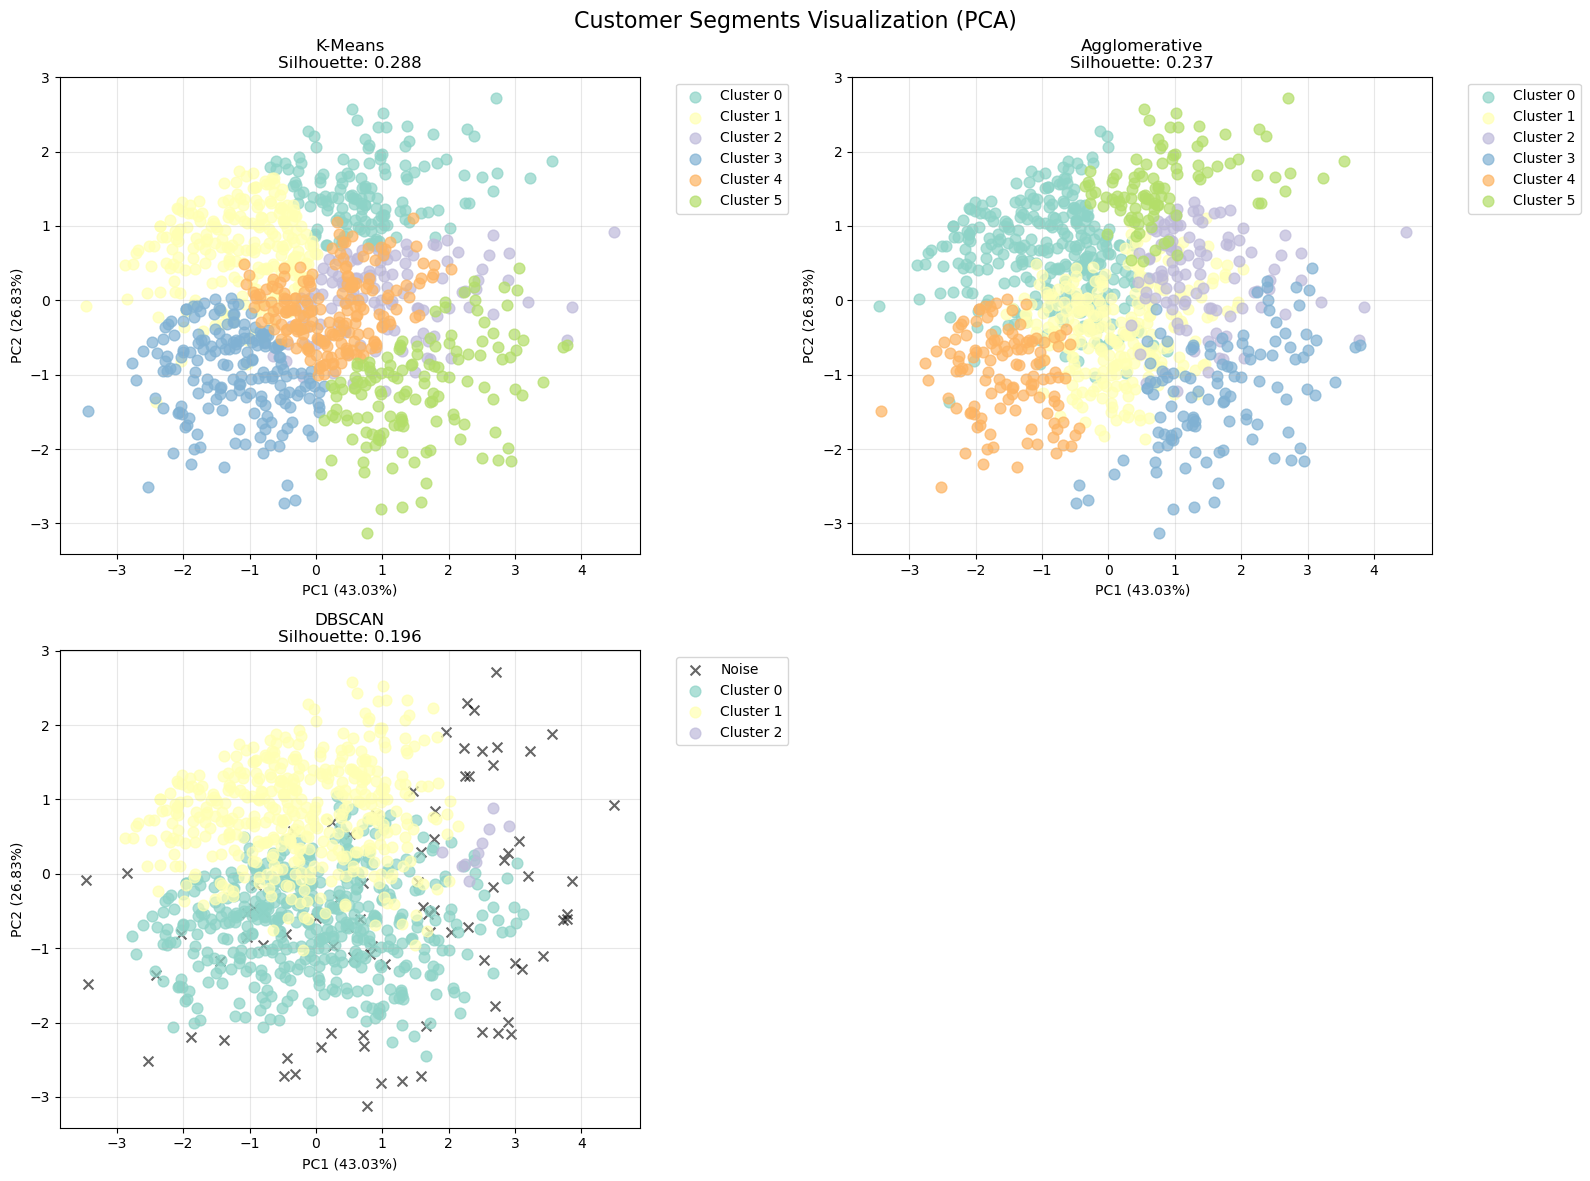

(PCA(n_components=2),
 array([[ 1.24865041, -1.30622586],
        [ 0.11688912, -1.15190738],
        [ 1.11303646, -0.32149126],
        ...,
        [ 0.95928851,  1.90611736],
        [-0.96770486, -0.56149845],
        [ 0.51507318,  0.01403064]]))

In [30]:
visualize_clusters_pca(X_scaled, clustering_results, feature_names)


In [31]:
# Step 7: Analyze and interpret clusters
def analyze_clusters(df, clustering_results, X_df, feature_names):
    """Detailed cluster analysis and business insights"""
    print("\n🔍 DETAILED CLUSTER ANALYSIS")
    print("-" * 40)
    
    # Use K-Means results as primary (usually most interpretable)
    primary_method = 'K-Means'
    if primary_method in clustering_results:
        labels = clustering_results[primary_method]['labels']
        
        # Add cluster labels to original dataframe
        df_with_clusters = df.copy()
        df_with_clusters['Cluster'] = labels
        
        # Analyze cluster characteristics
        print(f"📊 CLUSTER CHARACTERISTICS ({primary_method}):")
        print("-" * 50)
        
        cluster_summary = []
        for cluster_id in sorted(set(labels)):
            cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
            cluster_size = len(cluster_data)
            cluster_percent = (cluster_size / len(df)) * 100
            
            summary = {'Cluster': cluster_id, 'Size': cluster_size, 'Percentage': cluster_percent}
            
            # Calculate means for numerical features
            for col in df.select_dtypes(include=[np.number]).columns:
                if col in cluster_data.columns:
                    summary[f'{col}_mean'] = cluster_data[col].mean()
            
            # Most common categorical values
            for col in df.select_dtypes(include=['object']).columns:
                if col in cluster_data.columns and not col.lower().endswith('id'):
                    mode_val = cluster_data[col].mode()
                    summary[f'{col}_mode'] = mode_val[0] if len(mode_val) > 0 else 'N/A'
            
            cluster_summary.append(summary)
            
            print(f"\n🎯 CLUSTER {cluster_id}:")
            print(f"   Size: {cluster_size:,} customers ({cluster_percent:.1f}%)")
            
            # Print key characteristics
            for col in df.select_dtypes(include=[np.number]).columns:
                if col in cluster_data.columns and not col.lower().endswith('id'):
                    mean_val = cluster_data[col].mean()
                    overall_mean = df[col].mean()
                    diff_percent = ((mean_val - overall_mean) / overall_mean) * 100
                    direction = "↑" if diff_percent > 5 else "↓" if diff_percent < -5 else "→"
                    print(f"   {col}: {mean_val:.1f} {direction} ({diff_percent:+.1f}% vs avg)")
        
        # Create cluster comparison visualization
        cluster_df = pd.DataFrame(cluster_summary)
        
        # Visualize cluster characteristics
        numerical_features = [col for col in cluster_df.columns 
                            if col.endswith('_mean') and not col.lower().startswith('customer')]
        
        if len(numerical_features) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Cluster Characteristics Comparison', fontsize=16)
            axes = axes.ravel()
            
            for idx, feature in enumerate(numerical_features[:4]):
                if idx < 4:
                    cluster_df.plot(x='Cluster', y=feature, kind='bar', ax=axes[idx], 
                                  color=plt.cm.Set3(np.linspace(0, 1, len(cluster_df))))
                    axes[idx].set_title(f'{feature.replace("_mean", "").replace("_", " ").title()}')
                    axes[idx].set_xlabel('Cluster')
                    axes[idx].tick_params(axis='x', rotation=0)
                    axes[idx].grid(True, alpha=0.3)
            
            # Remove empty subplots
            for idx in range(len(numerical_features), 4):
                fig.delaxes(axes[idx])
            
            plt.tight_layout()
            plt.show()
        
        # Create business personas
        print(f"\n👥 CUSTOMER PERSONAS:")
        print("-" * 25)
        
        personas = {
            0: "Budget-Conscious Savers",
            1: "Premium High Spenders", 
            2: "Middle-Class Moderates",
            3: "Young Professionals",
            4: "Luxury Enthusiasts"
        }
        
        for cluster_id in sorted(set(labels)):
            cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster_id]
            persona_name = personas.get(cluster_id, f"Segment {cluster_id}")
            
            print(f"\n🏷️ {persona_name} (Cluster {cluster_id}):")
            print(f"   📊 {len(cluster_data)} customers ({len(cluster_data)/len(df)*100:.1f}%)")
            
            # Key characteristics
            if 'Age' in cluster_data.columns:
                avg_age = cluster_data['Age'].mean()
                print(f"   👤 Average Age: {avg_age:.1f} years")
            
            income_col = next((col for col in cluster_data.columns if 'income' in col.lower()), None)
            if income_col:
                avg_income = cluster_data[income_col].mean()
                print(f"   💰 Average Income: ${avg_income:,.0f}")
            
            spending_col = next((col for col in cluster_data.columns if 'spending' in col.lower()), None)
            if spending_col:
                avg_spending = cluster_data[spending_col].mean()
                print(f"   🛍️ Average Spending Score: {avg_spending:.1f}")
            
            if 'Gender' in cluster_data.columns:
                gender_dist = cluster_data['Gender'].value_counts()
                dominant_gender = gender_dist.index[0]
                gender_pct = gender_dist.iloc[0] / len(cluster_data) * 100
                print(f"   ⚥ Gender: {gender_pct:.0f}% {dominant_gender}")
        
        return df_with_clusters, cluster_summary
    
    return df, []




🔍 DETAILED CLUSTER ANALYSIS
----------------------------------------
📊 CLUSTER CHARACTERISTICS (K-Means):
--------------------------------------------------

🎯 CLUSTER 0:
   Size: 141 customers (14.1%)
   Age: 46.6 ↑ (+16.9% vs avg)
   Annual_Income: 29022.2 ↓ (-15.3% vs avg)
   Spending_Score: 44.1 ↓ (-24.0% vs avg)

🎯 CLUSTER 1:
   Size: 232 customers (23.2%)
   Age: 31.1 ↓ (-22.0% vs avg)
   Annual_Income: 25874.6 ↓ (-24.5% vs avg)
   Spending_Score: 65.1 ↑ (+12.3% vs avg)

🎯 CLUSTER 2:
   Size: 117 customers (11.7%)
   Age: 48.8 ↑ (+22.6% vs avg)
   Annual_Income: 52565.6 ↑ (+53.5% vs avg)
   Spending_Score: 59.3 → (+2.3% vs avg)

🎯 CLUSTER 3:
   Size: 184 customers (18.4%)
   Age: 29.0 ↓ (-27.2% vs avg)
   Annual_Income: 29899.9 ↓ (-12.7% vs avg)
   Spending_Score: 68.7 ↑ (+18.6% vs avg)

🎯 CLUSTER 4:
   Size: 188 customers (18.8%)
   Age: 41.9 ↑ (+5.1% vs avg)
   Annual_Income: 27039.9 ↓ (-21.1% vs avg)
   Spending_Score: 50.8 ↓ (-12.4% vs avg)

🎯 CLUSTER 5:
   Size: 138 custome

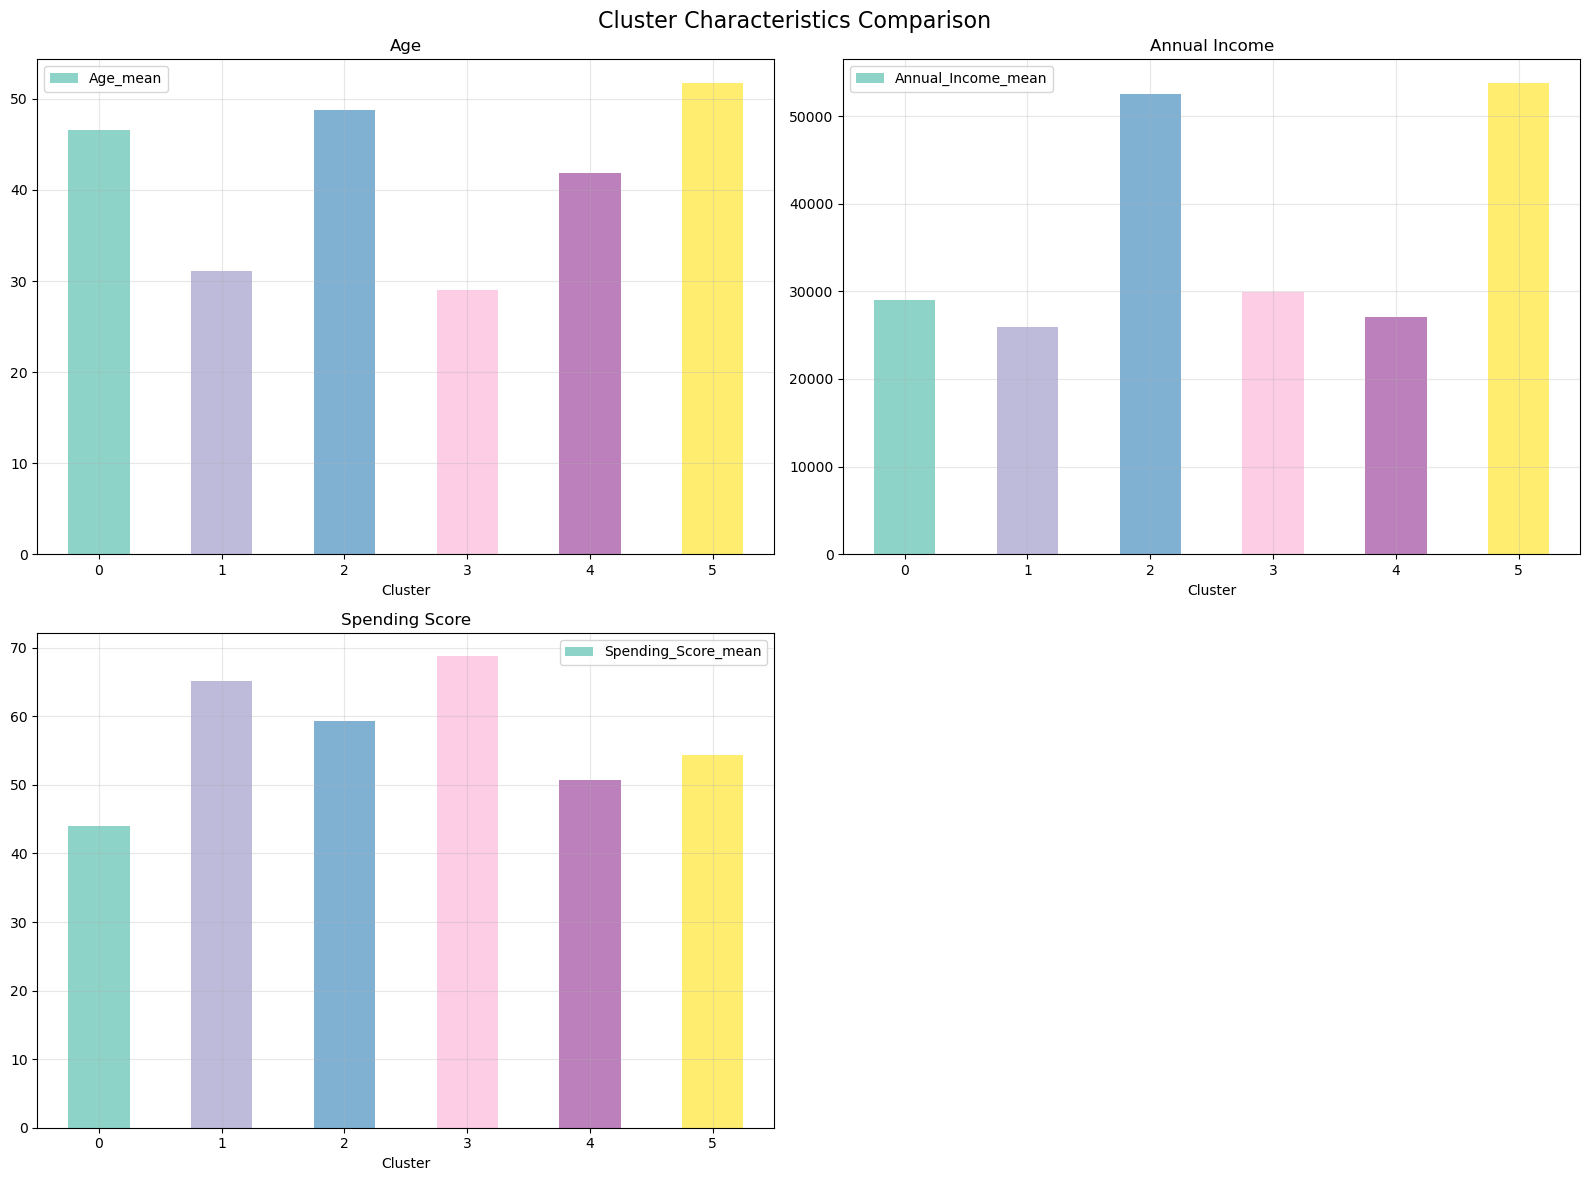


👥 CUSTOMER PERSONAS:
-------------------------

🏷️ Budget-Conscious Savers (Cluster 0):
   📊 141 customers (14.1%)
   👤 Average Age: 46.6 years
   💰 Average Income: $29,022
   🛍️ Average Spending Score: 44.1
   ⚥ Gender: 100% Male

🏷️ Premium High Spenders (Cluster 1):
   📊 232 customers (23.2%)
   👤 Average Age: 31.1 years
   💰 Average Income: $25,875
   🛍️ Average Spending Score: 65.1
   ⚥ Gender: 100% Male

🏷️ Middle-Class Moderates (Cluster 2):
   📊 117 customers (11.7%)
   👤 Average Age: 48.8 years
   💰 Average Income: $52,566
   🛍️ Average Spending Score: 59.3
   ⚥ Gender: 100% Male

🏷️ Young Professionals (Cluster 3):
   📊 184 customers (18.4%)
   👤 Average Age: 29.0 years
   💰 Average Income: $29,900
   🛍️ Average Spending Score: 68.7
   ⚥ Gender: 100% Female

🏷️ Luxury Enthusiasts (Cluster 4):
   📊 188 customers (18.8%)
   👤 Average Age: 41.9 years
   💰 Average Income: $27,040
   🛍️ Average Spending Score: 50.8
   ⚥ Gender: 100% Female

🏷️ Segment 5 (Cluster 5):
   📊 138 cust

In [32]:
df_with_clusters, cluster_summary=analyze_clusters(df, clustering_results, X_df, feature_names)


In [33]:
# Step 8: Business recommendations
def generate_business_recommendations(df_with_clusters, cluster_summary):
    """Generate actionable business insights and recommendations"""
    print("\n💼 BUSINESS RECOMMENDATIONS")
    print("-" * 40)
    
    print("🎯 MARKETING STRATEGIES BY SEGMENT:")
    print("-" * 45)
    
    for cluster in cluster_summary:
        cluster_id = cluster['Cluster']
        size = cluster['Size']
        
        print(f"\n📈 CLUSTER {cluster_id} STRATEGY ({size:,} customers):")
        
        # Income-based recommendations
        income_col = next((col for col in cluster.keys() if 'income' in col.lower() and 'mean' in col), None)
        spending_col = next((col for col in cluster.keys() if 'spending' in col.lower() and 'mean' in col), None)
        age_col = next((col for col in cluster))

In [34]:
generate_business_recommendations(df_with_clusters, cluster_summary)


💼 BUSINESS RECOMMENDATIONS
----------------------------------------
🎯 MARKETING STRATEGIES BY SEGMENT:
---------------------------------------------

📈 CLUSTER 0 STRATEGY (141 customers):

📈 CLUSTER 1 STRATEGY (232 customers):

📈 CLUSTER 2 STRATEGY (117 customers):

📈 CLUSTER 3 STRATEGY (184 customers):

📈 CLUSTER 4 STRATEGY (188 customers):

📈 CLUSTER 5 STRATEGY (138 customers):
